## Vision Transformer (ViT)

### Trabajo Práctico N° 1


## Tareas:

1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math
import time
import pandas as pd
import numpy as np
from contextlib import contextmanager

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')
        
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()

In [2]:
# Uso Context manager para medir el tiempo de ejecución de un bloque de código
@contextmanager
def temporizador(label=""): 
    inicio = time.time()
    try:
        yield
    finally:
        fin = time.time()
        return fin - inicio


def ejecutar_vit_parametrizado(img_path, img_size, patch_size, embed_dim, visualizar=False):
    tiempos = {}

    # Preprocesamiento
    inicio = time.time()
    config = ConfigPreprocess(img_path, img_size, patch_size)
    fin = time.time()
    tiempos['preprocesamiento'] = fin - inicio

    # Extracción de parches
    inicio = time.time()
    patches = config.extract_patches(config.test_img.squeeze(0))
    if visualizar:
        Visualization.visualize_patches(patches)
    fin = time.time()
    tiempos['extraccion_parches'] = fin - inicio

    # Generación de embeddings
    inicio = time.time()
    embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
    patches = embedded_patches(config.test_img)    
    fin = time.time()
    tiempos['generacion_embeddings'] = fin - inicio

    # Codificación posicional
    inicio = time.time()
    num_patches = (img_size // patch_size) ** 2
    positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)
    fin = time.time()
    tiempos['codificacion_posicional'] = fin - inicio

    # Visualizamos opcionalmente
    if visualizar:
        inicio = time.time()
        Visualization.visualize_positional_encoding(pos_embeddings)
        Visualization.visualize_single_patch_encoding(pos_embeddings, 0) # Hardcodeo el patch_idx igual a 0
        fin = time.time()
        tiempos['visualizacion'] = fin - inicio

    # Agregamos los datos adicionales para el análisis posterior
    tiempos['patch_size'] = patch_size
    tiempos['embed_dim'] = embed_dim
    tiempos['num_patches'] = num_patches
    tiempos["total"] = sum(
        v
        for k, v in tiempos.items()
        if isinstance(v, (int, float))
        and k not in ["patch_size", "embed_dim", "num_patches"]
    )

    # Estimaré el uso de memoria (MB)
    memoria_patches = (num_patches * 3 * patch_size * patch_size * 4) / (1024 * 1024)  # Parches originales en memoria
    memoria_embeddings = (num_patches * embed_dim * 4) / (1024 * 1024)  # Embeddings en memoria
    tiempos['memoria_patches_mb'] = memoria_patches
    tiempos['memoria_embeddings_mb'] = memoria_embeddings
    tiempos['memoria_total_mb'] = memoria_patches + memoria_embeddings

    return tiempos


- **Punto 1. Modificando los parámetros.**

In [3]:
# Parámetros
img_path = "raccoon.jpg"
img_size = 900 
#patch_sizes = [8, 16, 36, 80, 200] # Defino diferentes tamaño de parche a probar
patch_sizes = [16, 36, 60, 90, 180, 300] 
#embed_dims = [8, 16, 32, 64, 128, 256] # Defino diferentes dimensiones de embeddings
embed_dims = [8, 16, 32, 64, 128, 256] 
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

resultados = []

In [4]:
texto_analisis = "Inicio del análisis de parámetros"
print(texto_analisis)
print("-" * len(texto_analisis))

Inicio del análisis de parámetros
---------------------------------


In [5]:
for patch_size in patch_sizes:
    for embed_dim in embed_dims:
        # Verificamos que el tamaño del parche sea válido (divisor de img_size)
        if img_size % patch_size != 0:
            print(f"Saltando patch_size={patch_size} por que no es divisor de img_size={img_size}")
            continue

        print(f"Evaluando con patch_size={patch_size}, embed_dim={embed_dim}")
        try:
            resultado = ejecutar_vit_parametrizado(img_path, img_size, patch_size, embed_dim, visualizar=False) # Visualizar activo o no activo graficas
            resultados.append(resultado)
            num_patches = resultado['num_patches']
            print(f" Tiempo total: {resultado['total']:.4f}s, Num. parches: {num_patches}, Mem. aprox, {resultado['memoria_total_mb']:.2f} MB")
        except Exception as e:
            print(f"Error con patch_size={patch_size}, embed_dim={embed_dim}: {str(e)}")
        print("-"*30)

Saltando patch_size=16 por que no es divisor de img_size=900
Saltando patch_size=16 por que no es divisor de img_size=900
Saltando patch_size=16 por que no es divisor de img_size=900
Saltando patch_size=16 por que no es divisor de img_size=900
Saltando patch_size=16 por que no es divisor de img_size=900
Saltando patch_size=16 por que no es divisor de img_size=900
Evaluando con patch_size=36, embed_dim=8
Dispositivo utilizado: cuda
 Tiempo total: 0.2396s, Num. parches: 625, Mem. aprox, 9.29 MB
------------------------------
Evaluando con patch_size=36, embed_dim=16
Dispositivo utilizado: cuda
 Tiempo total: 0.0312s, Num. parches: 625, Mem. aprox, 9.31 MB
------------------------------
Evaluando con patch_size=36, embed_dim=32
Dispositivo utilizado: cuda
 Tiempo total: 0.0292s, Num. parches: 625, Mem. aprox, 9.35 MB
------------------------------
Evaluando con patch_size=36, embed_dim=64
Dispositivo utilizado: cuda
 Tiempo total: 0.0299s, Num. parches: 625, Mem. aprox, 9.42 MB
----------

In [6]:
# Convertimos a DataFrame para un mejor análisis
df_resultados = pd.DataFrame(resultados)
print(f"\nResultados completos:")
print(df_resultados[['patch_size', 'embed_dim', 'num_patches', 'total', 'memoria_total_mb']])

# Guardamos los resultados en un archivo 
df_resultados.to_csv('tp1_resultados.csv', index=False)
print("\nResultados guardados en 'tp1_resultados.csv'")



Resultados completos:
    patch_size  embed_dim  num_patches     total  memoria_total_mb
0           36          8          625  0.239557          9.288788
1           36         16          625  0.031241          9.307861
2           36         32          625  0.029187          9.346008
3           36         64          625  0.029882          9.422302
4           36        128          625  0.031257          9.574890
5           36        256          625  0.032311          9.880066
6           60          8          225  0.028703          9.276581
7           60         16          225  0.029490          9.283447
8           60         32          225  0.031033          9.297180
9           60         64          225  0.036348          9.324646
10          60        128          225  0.034702          9.379578
11          60        256          225  0.042585          9.489441
12          90          8          100  0.030680          9.272766
13          90         16          100 

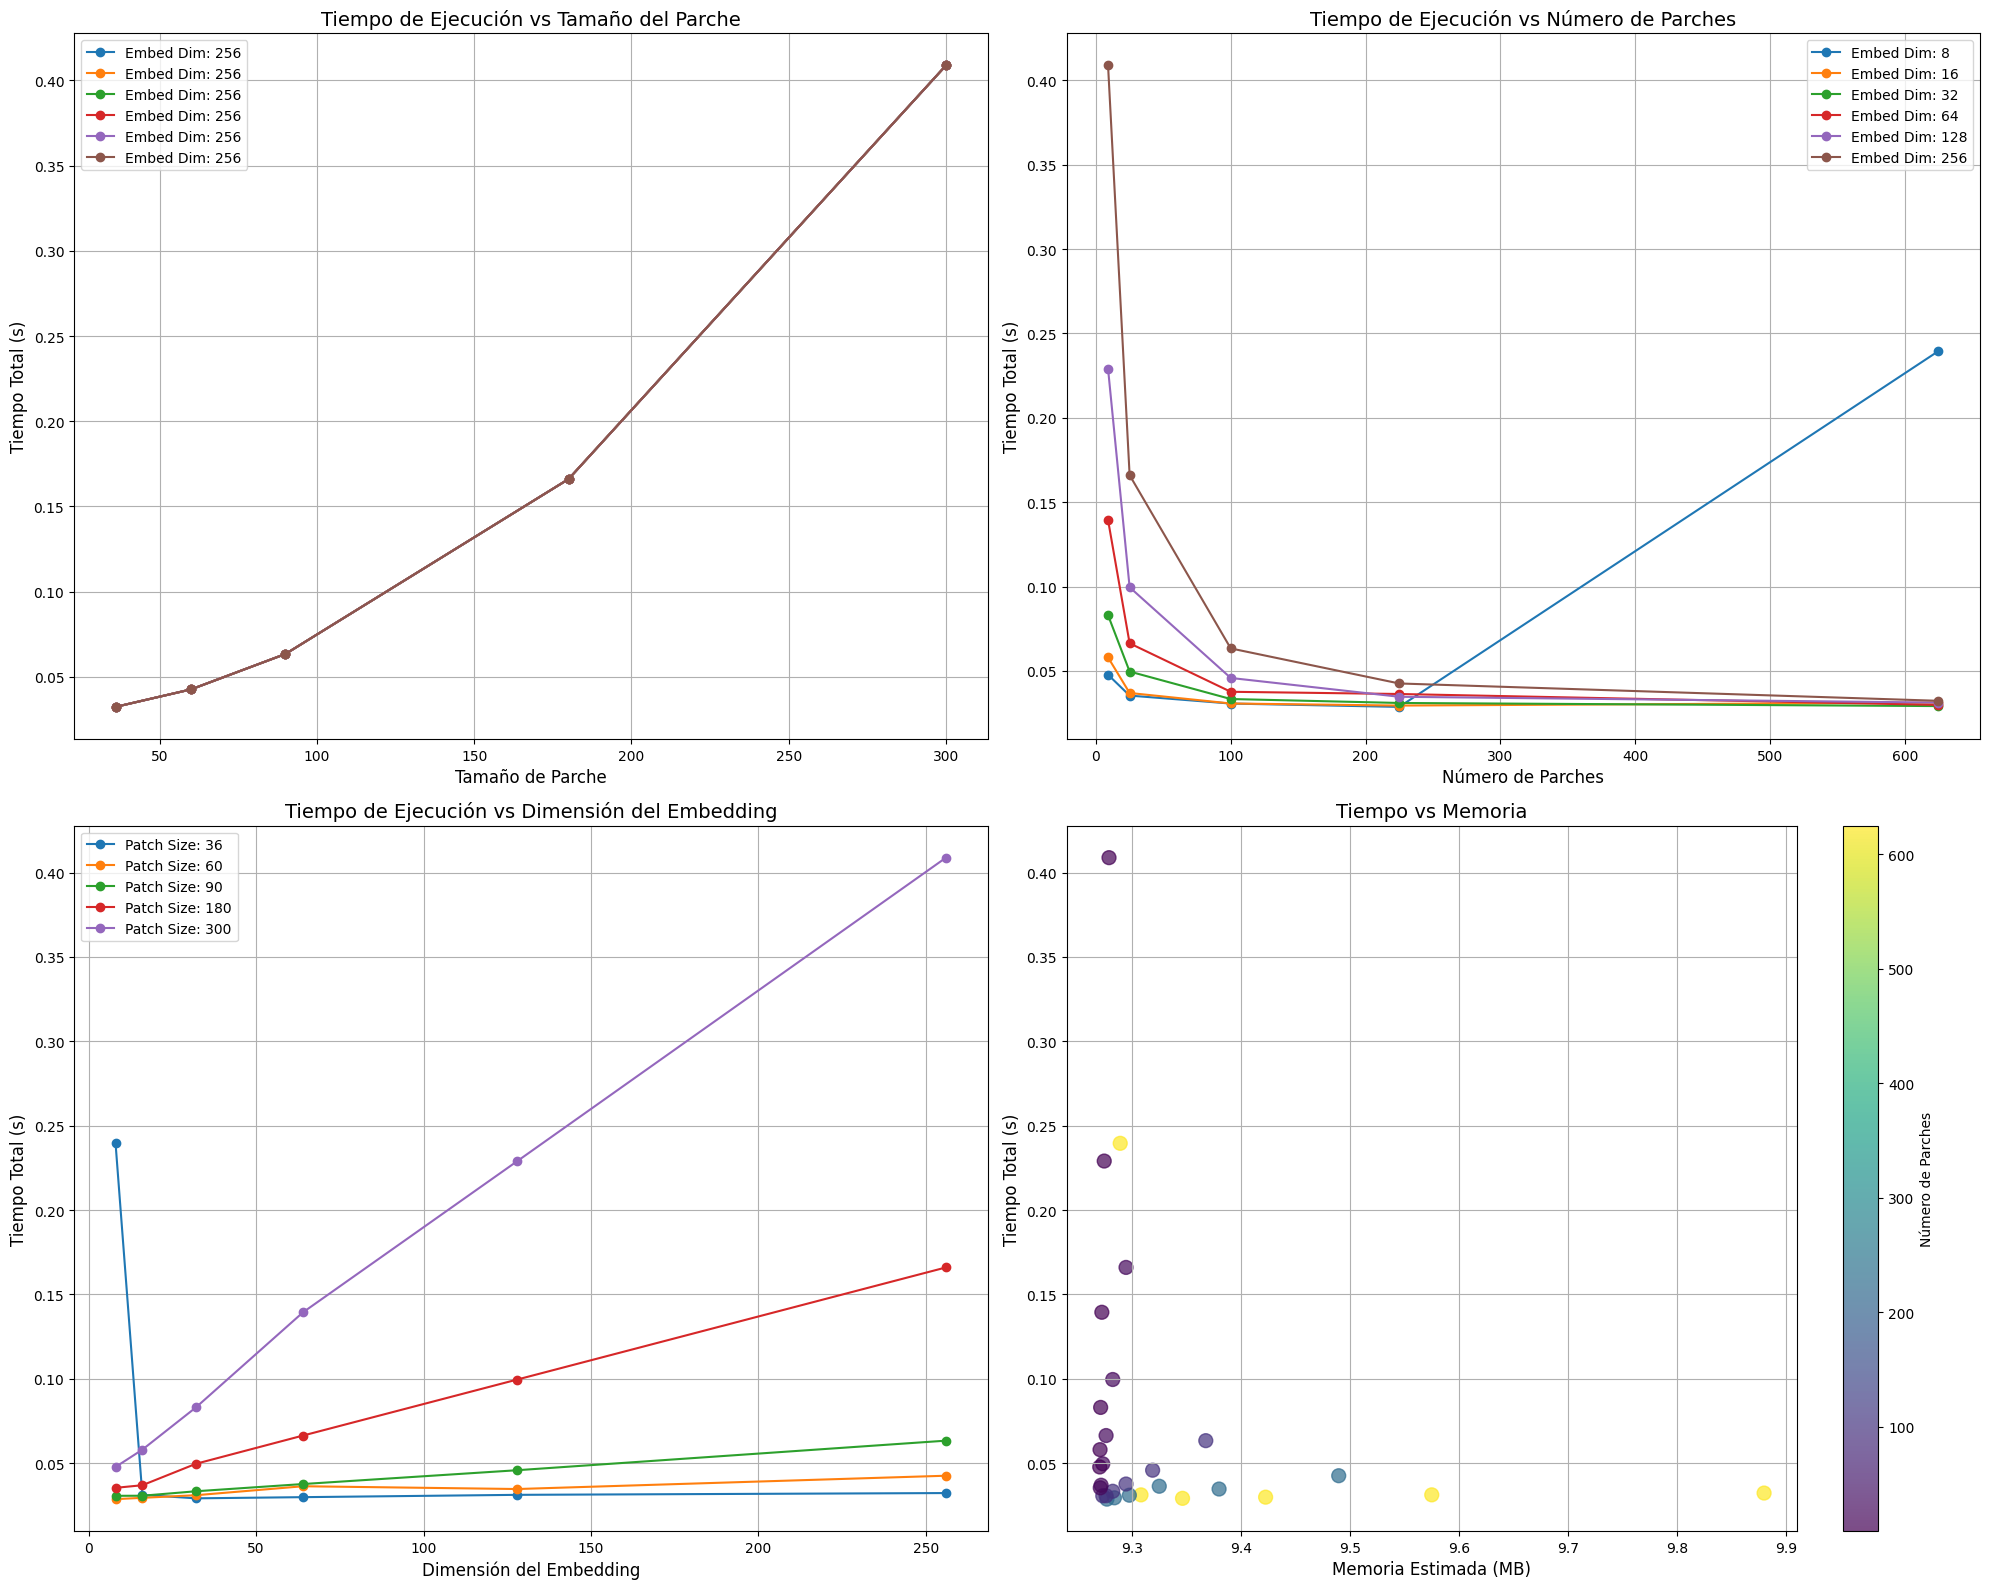


Gráficos guardados en 'tp1_analisis_parametros.png'


In [7]:
# Visualización de resultados
plt.figure(figsize=(20, 16))

# Gráfico 1: Tiempo total vs Tamaño de parche por dimensión de embedding
plt.subplot(2, 2, 1)
for embedd_dim in embed_dims:
    datos = df_resultados[df_resultados['embed_dim'] == embed_dim]
    if not datos.empty:
        plt.plot(datos['patch_size'], datos['total'], 'o-', label=f'Embed Dim: {embed_dim}')

plt.xlabel('Tamaño de Parche', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.title('Tiempo de Ejecución vs Tamaño del Parche', fontsize=14)
plt.legend()
plt.grid(True)

# Gráfico 2: Tiempo total vs Número de parches por dimensión de embedding
plt.subplot(2, 2, 2)
for embed_dim in embed_dims:
    datos = df_resultados[df_resultados['embed_dim'] == embed_dim]
    if not datos.empty:
        plt.plot(datos['num_patches'], datos['total'], 'o-', label=f'Embed Dim: {embed_dim}')
plt.xlabel('Número de Parches', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.title('Tiempo de Ejecución vs Número de Parches', fontsize=14)
plt.legend()
plt.grid(True)

# Gráfico 3: Tiempo total vs Dimensión de embedding por tamaño de parche
plt.subplot(2, 2, 3)
for patch_size in patch_sizes:
    datos = df_resultados[df_resultados['patch_size'] == patch_size]
    if not datos.empty:
        plt.plot(datos['embed_dim'], datos['total'], 'o-', label=f'Patch Size: {patch_size}')
plt.xlabel('Dimensión del Embedding', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.title('Tiempo de Ejecución vs Dimensión del Embedding', fontsize=14)
plt.legend()
plt.grid(True)

# Gráfico 4: Memoria vs Tiempo (scatter plot con colores por dimensión)
plt.subplot(2, 2, 4)
scatter = plt.scatter(df_resultados['memoria_total_mb'], df_resultados['total'], 
                     c=df_resultados['num_patches'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter, label='Número de Parches')
plt.xlabel('Memoria Estimada (MB)', fontsize=12)
plt.ylabel('Tiempo Total (s)', fontsize=12)
plt.title('Tiempo vs Memoria', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.savefig("tp1_analisis_parametros.png")
plt.show()

print("\nGráficos guardados en 'tp1_analisis_parametros.png'")

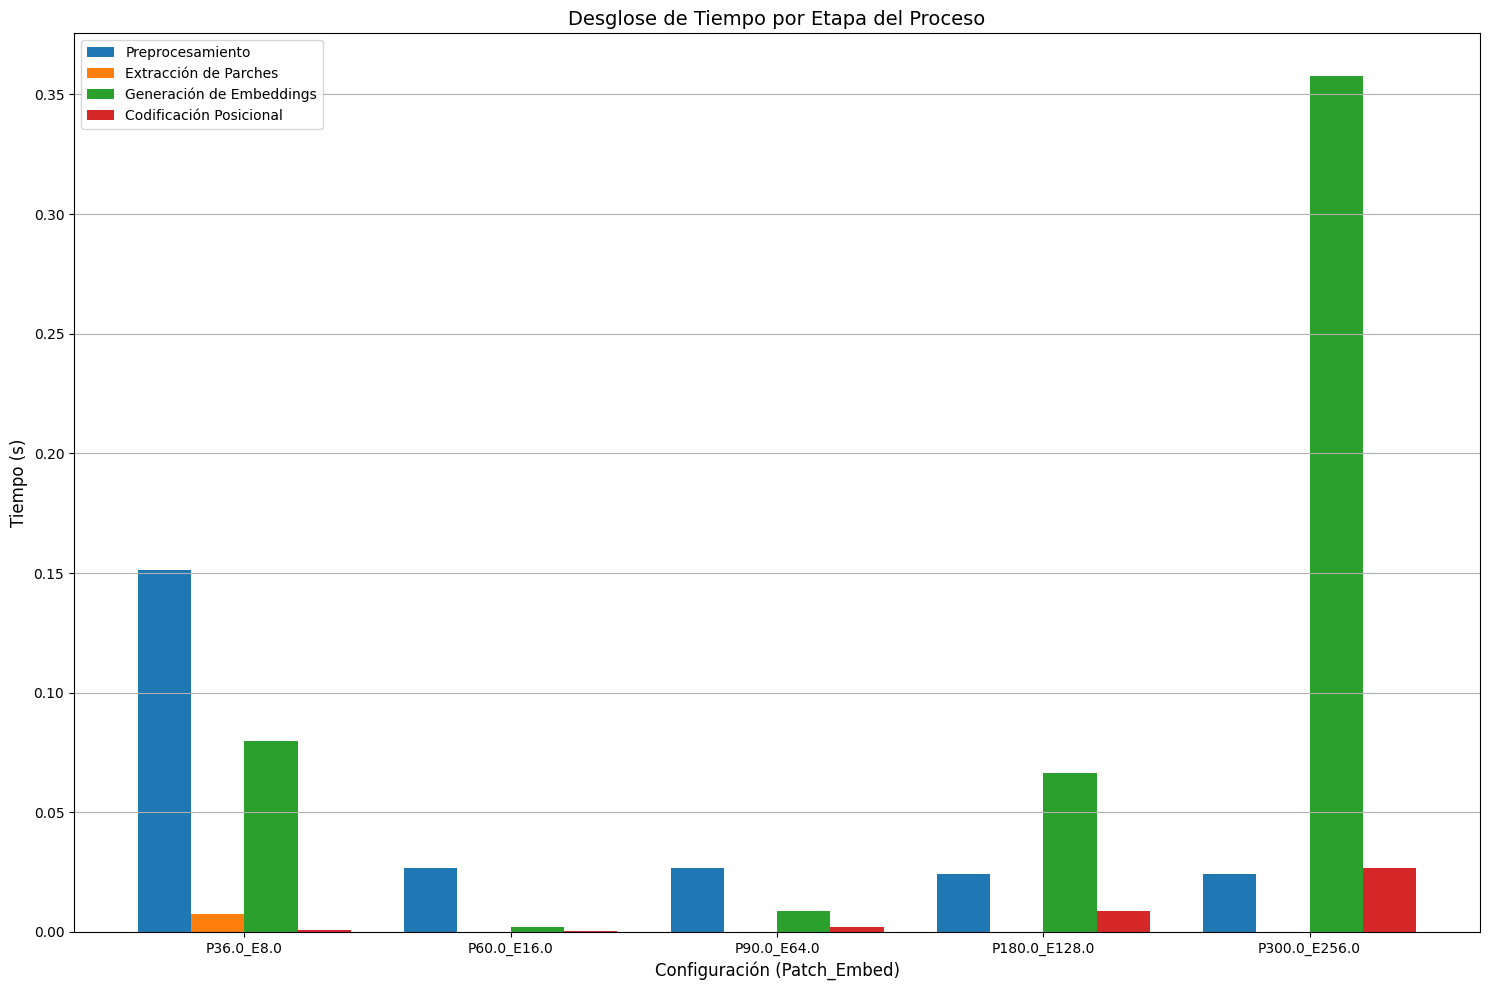


Desglose de tiempos guardado en 'tp1_desglose_tiempos.png'


In [8]:
# Análisis adicional: Desglose de tiempo por etapa
plt.figure(figsize=(15, 10))

# Seleccionamos algunas configuraciones representativas para mostrar desglose de tiempo
configs_representativas = df_resultados.iloc[[0, len(df_resultados)//4, len(df_resultados)//2, 3*len(df_resultados)//4, -1]]

labels = [f"P{row['patch_size']}_E{row['embed_dim']}" for _, row in configs_representativas.iterrows()]
preprocesamiento = configs_representativas['preprocesamiento']
extraccion = configs_representativas['extraccion_parches']
embeddings = configs_representativas['generacion_embeddings']
posicional = configs_representativas['codificacion_posicional']

x = np.arange(len(labels))
width = 0.2

plt.bar(x - 1.5*width, preprocesamiento, width, label='Preprocesamiento')
plt.bar(x - 0.5*width, extraccion, width, label='Extracción de Parches')
plt.bar(x + 0.5*width, embeddings, width, label='Generación de Embeddings')
plt.bar(x + 1.5*width, posicional, width, label='Codificación Posicional')

plt.xlabel('Configuración (Patch_Embed)', fontsize=12)
plt.ylabel('Tiempo (s)', fontsize=12)
plt.title('Desglose de Tiempo por Etapa del Proceso', fontsize=14)
plt.xticks(x, labels)
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig("tp1_desglose_tiempos.png")
plt.show()

print("\nDesglose de tiempos guardado en 'tp1_desglose_tiempos.png'")
